In [1]:
import os

import torch
import torch.nn as nn;
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights
from torchvision.datasets import Food101
from torchvision.transforms import transforms

from modelpipe import ClassifierHead


**Base Model Prototyping**

Loading Data

In [11]:
# os.chdir("..")
# root_path = os.getcwd()
# ds_path = os.path.join(root_path, "datasets")
ds_path = 'c:\\Users\\amany\\OneDrive\\Desktop\\projects\\genAi\\VitModel\\Main\\datasets'

In [12]:
train_transform = transforms.Compose([transforms.Resize((384, 384)), transforms.ToTensor()])
valid_transform = transforms.Compose([transforms.ToTensor()])

In [13]:
trainset = Food101(root=ds_path, download=True, split='train', transform=train_transform)
testset  = Food101(root=ds_path, download=True, split='test', transform=valid_transform)

In [14]:
train_loader = DataLoader(trainset, batch_size=32, shuffle = True)

test_loader = DataLoader(testset, batch_size=32, shuffle = True)

In [15]:
sample_batch = next(iter(train_loader))
sample_batch[0].shape

torch.Size([32, 3, 384, 384])

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [17]:
sample_batch[0][0].shape

torch.Size([3, 384, 384])

Base Model

In [18]:
pretrained_model = efficientnet_v2_s(weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1)

In [26]:
class PretrainedBaseModel(nn.Module):
    def __init__(self, pretrained_model:nn.Module, freeze_model=True):
        super(PretrainedBaseModel, self).__init__()
        self.pt_model = pretrained_model
        self.model = self.pt_model.features

        if freeze_model:
            self.freeze();

    def freeze(self):
        for params in self.model.parameters():
            params.requires_grad = False
        self.model.eval() #to prevent batchnorm running -stats(mean & std) update (?)

    def forward(self, x):
        return self.model(x)


In [24]:
base_model = PretrainedBaseModel(pretrained_model)

In [ ]:
for name, params in base_model.named_parameters():
    if params.requires_grad)

pt_model.features.0.0.weight False
pt_model.features.0.1.weight False
pt_model.features.0.1.bias False
pt_model.features.1.0.block.0.0.weight False
pt_model.features.1.0.block.0.1.weight False
pt_model.features.1.0.block.0.1.bias False
pt_model.features.1.1.block.0.0.weight False
pt_model.features.1.1.block.0.1.weight False
pt_model.features.1.1.block.0.1.bias False
pt_model.features.2.0.block.0.0.weight False
pt_model.features.2.0.block.0.1.weight False
pt_model.features.2.0.block.0.1.bias False
pt_model.features.2.0.block.1.0.weight False
pt_model.features.2.0.block.1.1.weight False
pt_model.features.2.0.block.1.1.bias False
pt_model.features.2.1.block.0.0.weight False
pt_model.features.2.1.block.0.1.weight False
pt_model.features.2.1.block.0.1.bias False
pt_model.features.2.1.block.1.0.weight False
pt_model.features.2.1.block.1.1.weight False
pt_model.features.2.1.block.1.1.bias False
pt_model.features.2.2.block.0.0.weight False
pt_model.features.2.2.block.0.1.weight False
pt_model.

In [19]:
x, y = trainset[0]

In [20]:
x = x.view(1, *x.shape)
x.shape

torch.Size([1, 3, 384, 384])

In [25]:
op = base_model(x)
op.shape

torch.Size([1, 1000])

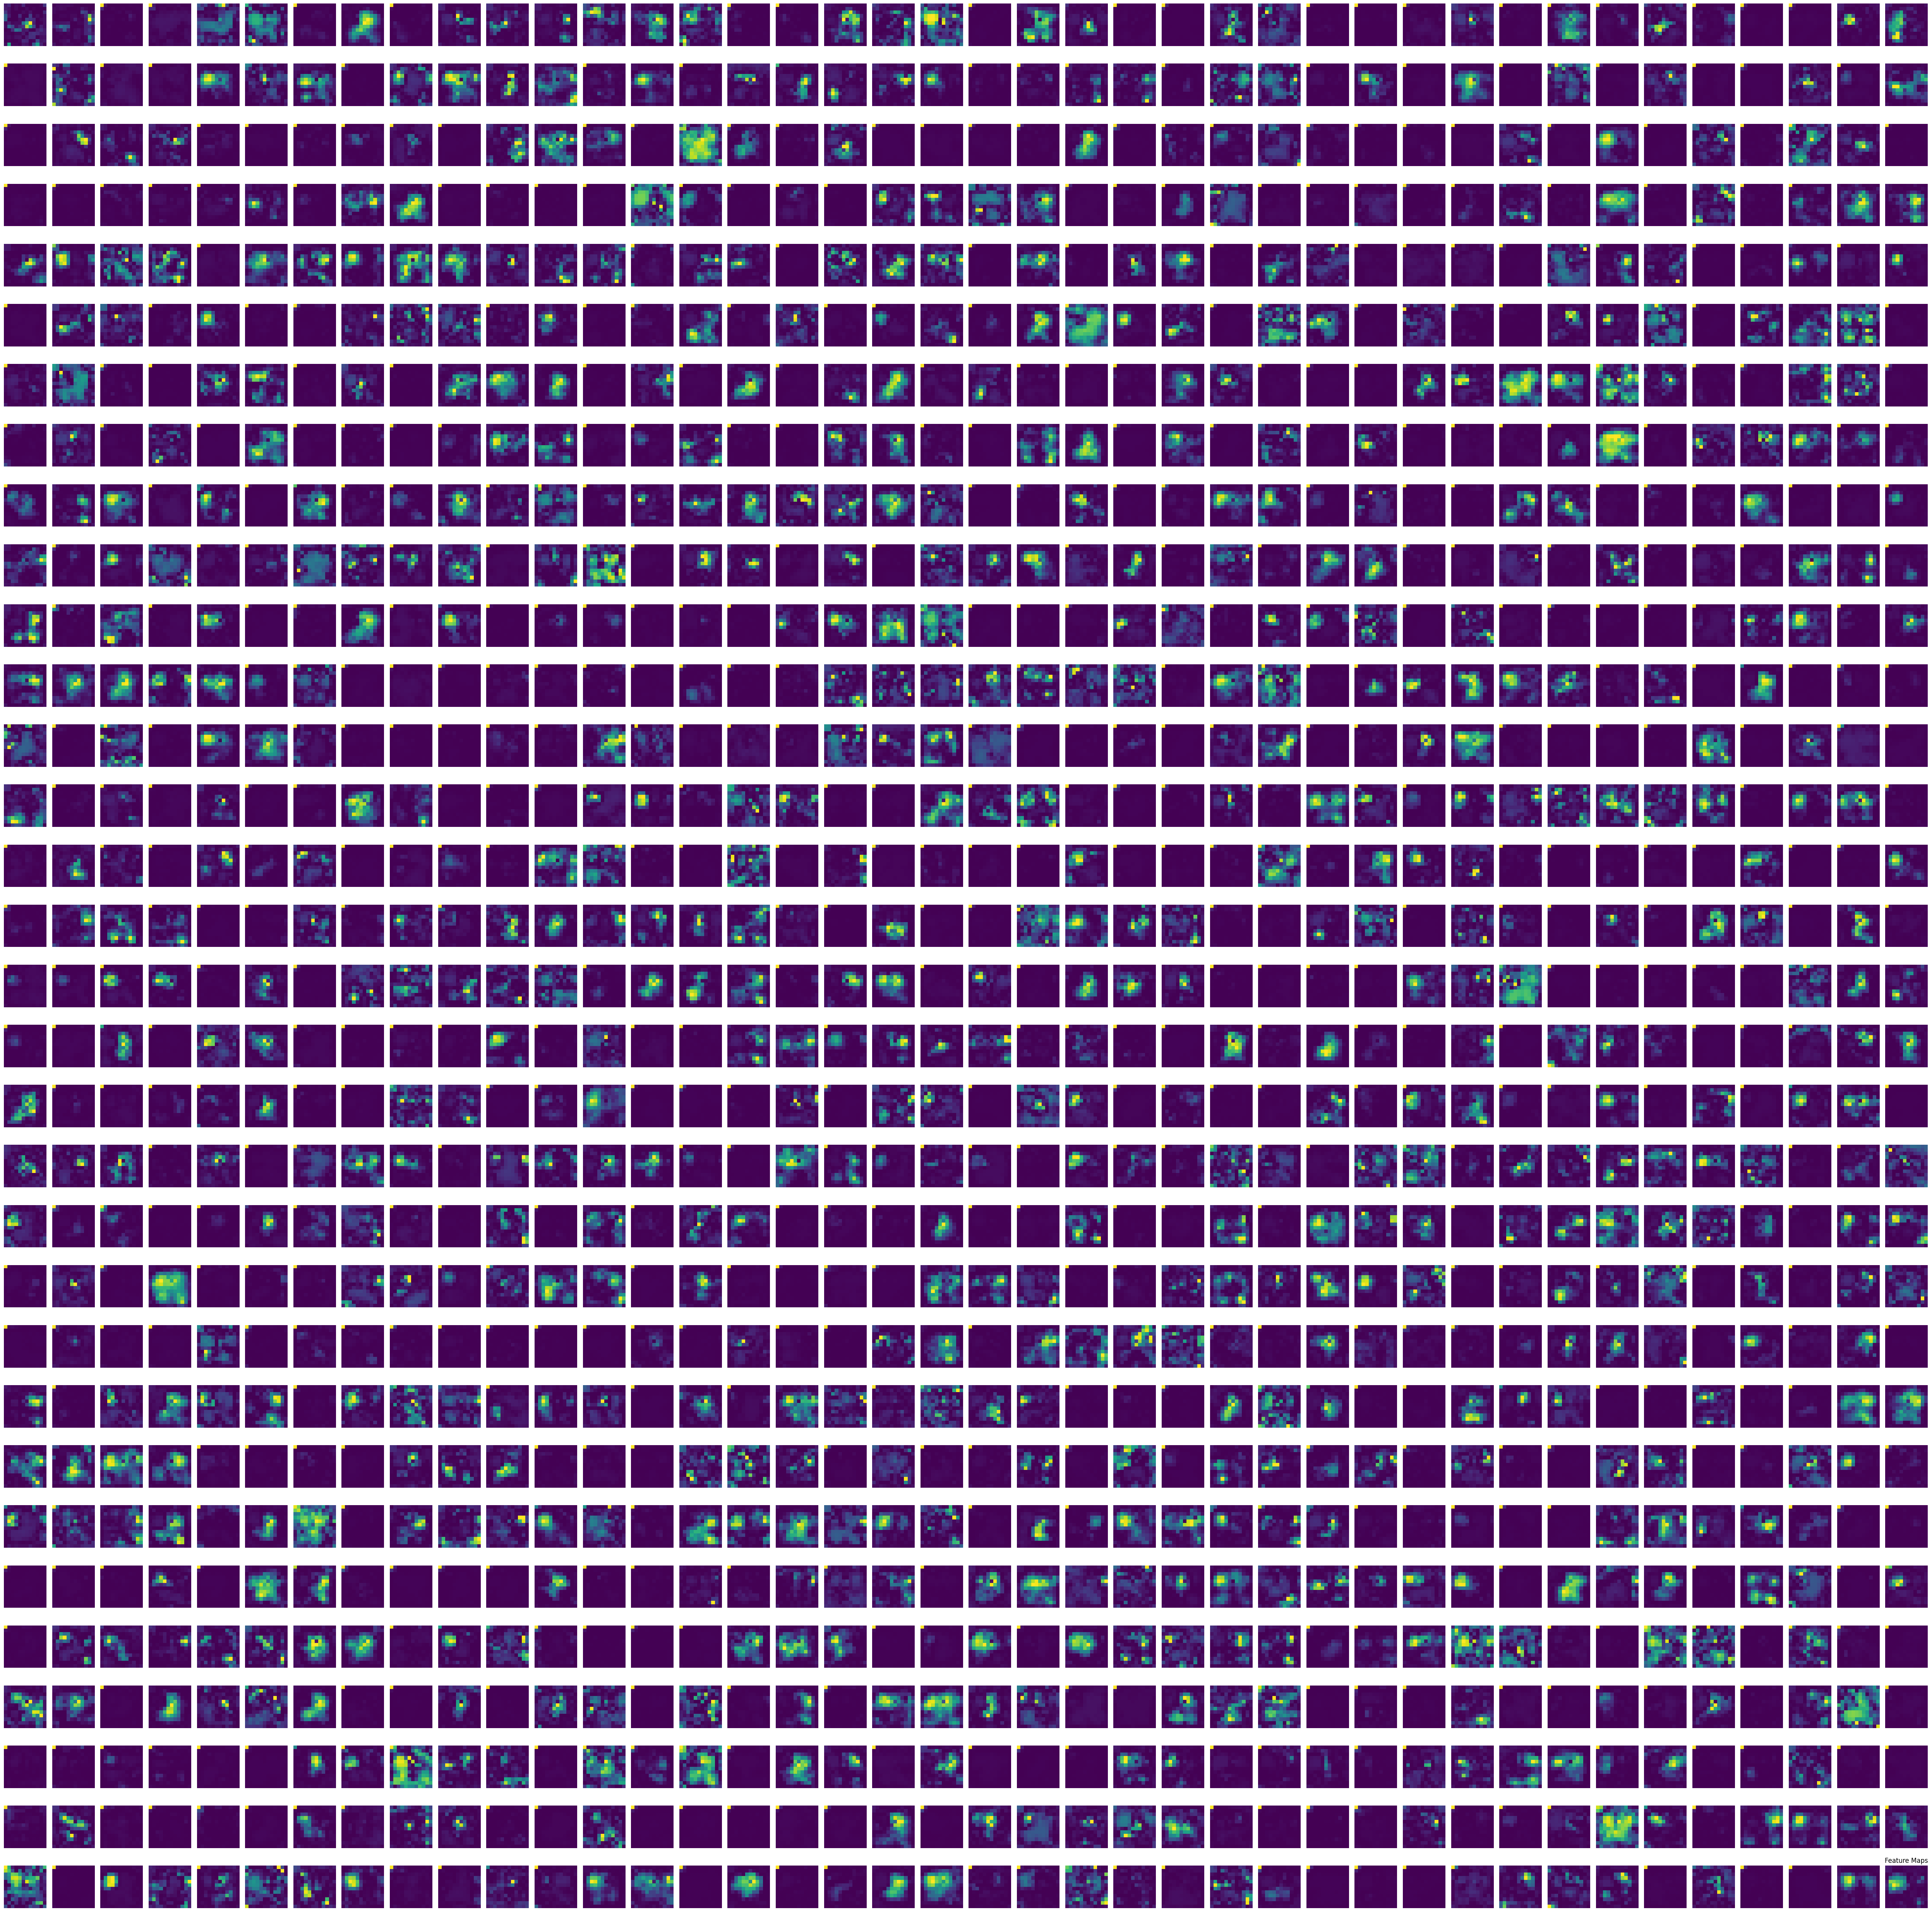

In [15]:

fig, axes = plt.subplots(32, 40, figsize=(50, 50))

for ax, img in zip(axes.flatten(), op[0]):
    ax.imshow(img)
    ax.axis("off")

plt.tight_layout()
plt.axis("off")
plt.title("Feature Maps")
plt.show()

**PATCHIFICATION**

In [16]:
dmodel = 784

In [17]:
batch_out = base_model(sample_batch[0])

Output dimensions from the last convolutional layers of efficientnet model: C x H x W:1280 x 16 x 16
Now we have to convert this these feature maps into patches
Its anolougouse to having 16 x 16 --> 256 tokens projected in 1280 dimensions
As per the original vit paper https://arxiv.org/pdf/2010.11929 , hybrid vit implements 1x1 convolution on the featuremaps.

In [18]:
cls_token =torch.zeros(1, 1, dmodel)
cls_token.shape

torch.Size([1, 1, 784])

In [114]:
class PatchEmbeddings(nn.Module):
    def __init__(self, d_model=dmodel, in_feat=1280, out_feat=dmodel, kernel=1, stride=1):
        super(PatchEmbeddings, self).__init__()
        self.patch_conv = nn.Conv2d(in_feat, out_feat, kernel_size=kernel, stride=stride)
        self.batch_norm = nn.BatchNorm2d(out_feat)
        self.norm = nn.LayerNorm(out_feat)

    def forward(self, x):
        out = self.patch_conv(x)
        out = self.batch_norm(out)
        b, c, h, w = out.size()
        out =  out.reshape(b, c, h*w).permute(0, 2, 1)
        out = self.norm(out)

        return out
        

In [115]:
patchemb = PatchEmbeddings()
patchs = patchemb(batch_out)

In [116]:
patchs.shape

torch.Size([32, 144, 784])

**Positional Encodings**

In [22]:
# div_term = 1/(10000)^(2*i/dmodel) where i is the index in embeddings and dmodel is the embeding dimension
#to make calculation easy we here, find div_term for every varlue of 2*i where 2*i is even 
#thereby getting a tensor of div term for every index of embeddings

tokens = 100
pe = torch.zeros(tokens, dmodel)
emb_idx = torch.arange(0, dmodel, 2)
pos = torch.arange(100).unsqueeze(1)#token positions.

div_term = torch.exp(-(emb_idx/dmodel)*torch.log(torch.tensor(10000)))
pe[:, 0:dmodel:2] = torch.sin(pos * div_term)
pe[:, 1:dmodel:2] = torch.cos(pos * div_term)

In [23]:
pe[:50].unsqueeze(0).shape

torch.Size([1, 50, 784])

In [24]:
pe.shape

torch.Size([100, 784])

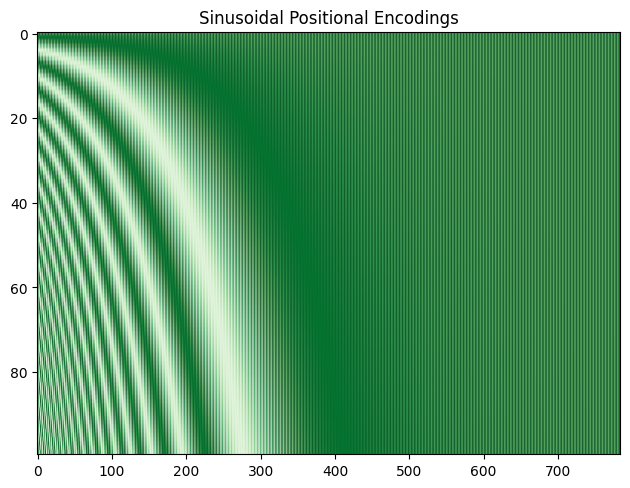

In [25]:
plt.imshow(pe, aspect='auto', cmap="Greens")
plt.tight_layout()
plt.title("Sinusoidal Positional Encodings")
plt.show()

In [124]:
import math

class PositionalEncodings(nn.Module):
    def __init__(self, seq_len=5000, emb_dim=dmodel):
        super(PositionalEncodings, self).__init__()
        self.emb_dim = emb_dim
        pe = torch.zeros(seq_len, emb_dim)
        emb_idx = torch.arange(0, emb_dim//2, dtype=torch.float32)
        div_terms = torch.exp(-(2*emb_idx/emb_dim) * math.log(10000))
        pos = torch.arange(seq_len).unsqueeze(1)

        pe[:, 0:emb_dim:2] = torch.sin(pos * div_terms)
        pe[:, 1:emb_dim:2] = torch.cos(pos * div_terms)

        self.register_buffer("pe",pe)

    def encoding_img(self):
        plt.imshow(self.pe.T, cmap='BuGn', aspect='auto')
        plt.tight_layout()
        plt.title("Sinusoidal Positional Encodings")
        plt.xlabel("Token IDs")
        plt.ylabel("Encoding Index")
        plt.show()

    def forward(self, x):
        assert x.size(1) <= self.pe.size(0), "Sequence length exceeds max_seq length"
        return x + self.pe[:x.size(1)].unsqueeze(0)

In [125]:
pE = PositionalEncodings(emb_dim=dmodel)

In [126]:
final_embs = pE(patchs)

In [127]:
patchs.shape

torch.Size([32, 144, 784])

In [30]:
patchs.shape

torch.Size([32, 145, 784])

In [31]:
final_embs.shape

torch.Size([32, 145, 784])

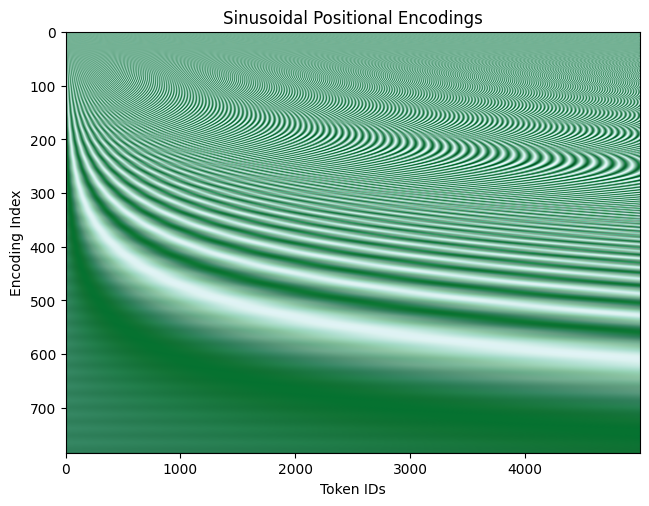

In [123]:
pE.encoding_img()

**Transform Archietecture Design for VIT**

*Transformer Encoder with MultiheadSelfAttention*

*MultiheadSelfAttention Mechanism*

In [33]:
final_embs.shape

torch.Size([32, 145, 784])

In [34]:
final_embs[0].unsqueeze(0).shape

torch.Size([1, 145, 784])

In [35]:
heads = 4
head_dim = dmodel//heads
head_dim

196

In [36]:

sample = nn.Linear(dmodel, dmodel)(final_embs[0].unsqueeze(0))
sample.shape

torch.Size([1, 145, 784])

In [37]:
sample = sample.view(1, -1, heads, head_dim).transpose(2, 1)
sample.shape

torch.Size([1, 4, 145, 196])

In [38]:
score = sample @ sample.transpose(-2, -1)
score.shape

torch.Size([1, 4, 145, 145])

In [39]:
score = torch.softmax(score, dim=-1)/dmodel**0.5
score.shape

torch.Size([1, 4, 145, 145])

In [40]:
(score[0][0] @ sample[0][0]).shape

torch.Size([145, 196])

In [41]:
score = (score @ sample)
score.shape

torch.Size([1, 4, 145, 196])

In [42]:
score.shape

torch.Size([1, 4, 145, 196])

In [43]:
score = score.transpose(2, 1)
score.shape

torch.Size([1, 145, 4, 196])

In [44]:
score.reshape(1, -1, dmodel).shape

torch.Size([1, 145, 784])

In [45]:

class MultiHeadSelfAttention(nn.Module):
    def __init__(self, nhead=4, d_model=784):
        super(MultiHeadSelfAttention, self).__init__()
        assert d_model%nhead == 0
        self.nhead = nhead

        self.Wq = nn.Linear(d_model, d_model)
        self.Wk = nn.Linear(d_model, d_model)
        self.Wv = nn.Linear(d_model, d_model)
        self.Wo = nn.Linear(d_model, d_model)

        self.norm = nn.LayerNorm(d_model)

        self.head_dim  = d_model//nhead

    def attention(self, Q, K, V):
        B, N, D = Q.shape

        Q = Q.reshape(B, N, self.nhead, self.head_dim).transpose(1, 2)
        K = K.reshape(B, N, self.nhead, self.head_dim).transpose(1, 2)
        V = V.reshape(B, N, self.nhead, self.head_dim).transpose(1, 2)

        out = Q @ K.transpose(-2, -1)
        out = torch.softmax(out/(self.head_dim ** (0.5)),dim=-1)
        out = torch.matmul(out, V) #(B, H, N, HD) H-->No. of heads, HD-->Head dims
        out = out.transpose(1, 2) #(B, N, H, HD) 
        
        return out.contiguous().view(B, N, D)

    def forward(self, x):
        Q = self.Wq(x)
        K = self.Wk(x)
        V = self.Wv(x)
        
        attn = self.Wo(self.attention(Q, K, V))

        return self.norm(x+attn)


In [46]:
attn = MultiHeadSelfAttention(d_model=dmodel, nhead=4)

In [47]:
attn = attn(final_embs)

In [48]:
attn.shape

torch.Size([32, 145, 784])

*Transformer Encoder Layer*

In [49]:
class TransformerEncoderLayer(nn.Module):
    def __init__(self, emb_dim=784,nhead=4):
        super(TransformerEncoderLayer, self).__init__()
        self.emb_dim = emb_dim
        self.mhsa = MultiHeadSelfAttention(nhead=nhead, d_model=emb_dim)
        self.norm = nn.LayerNorm(emb_dim)

        self.model = nn.Sequential(nn.Linear(emb_dim, emb_dim*4), nn.GELU(), 
                                   nn.Linear(emb_dim*4, emb_dim))

    def forward(self, x):
        x = self.mhsa(x)
        x = x + self.model(x)
        return self.norm(x)
        


*Transfromer Encoder*

In [50]:
class TransformerEncoder(nn.Module):
    def __init__(self, num_layers, nheads=4, emb_dim=784):
        super(TransformerEncoder, self).__init__()
        self.encoder = nn.ModuleList([TransformerEncoderLayer(emb_dim=emb_dim, nhead=nheads) for _ in range(num_layers)])
        
    def forward(self, x):
        for layer in self.encoder:
            x = layer(x)
        return x


Final Model

In [71]:
class ClassifierHead(nn.Module):
    def __init__(self, in_feat, out_feat, **kwargs):
        super(ClassifierHead, self).__init__()

        self.hidden = [in_feat//2**(i+1) for i in range(2)]
        self.hidden = self.hidden + list(reversed(self.hidden))

            
        self.fnn_in = nn.Linear(in_feat, self.hidden[0])
        self.fnn = nn.ModuleList()

        for _in, _out in zip(self.hidden, self.hidden[1:]):
            self.fnn.append(nn.Linear(_in, _out))
            self.fnn.append(nn.GELU())

        self.fnn_out = nn.Linear(self.hidden[-1], out_feat)
        self.probs = nn.Softmax()

    def forward(self, x):
        x = self.fnn_in(x)

        for layer in self.fnn:
            x = layer(x)

        x = self.fnn_out(x)
        return self.probs(x)


        

In [72]:
head = ClassifierHead(5, 10)

In [73]:
head

ClassifierHead(
  (fnn_in): Linear(in_features=5, out_features=2, bias=True)
  (fnn): ModuleList(
    (0): Linear(in_features=2, out_features=1, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=1, out_features=1, bias=True)
    (3): GELU(approximate='none')
    (4): Linear(in_features=1, out_features=2, bias=True)
    (5): GELU(approximate='none')
  )
  (fnn_out): Linear(in_features=2, out_features=10, bias=True)
  (probs): Softmax(dim=None)
)

In [ ]:
class HybridVitNet(nn.Module):
    def __init__(self, 
                 base_model=None, 
                 pretrained_model=None, 
                 patchifier=None, 
                 pos_encoder=None, 
                 encoder=None,
                 classifier=None,
                 num_classes=None,
                 num_layers=10,
                 nheads=4, 
                 emb_dim=784, 
                 in_channels=1280, 
                 kernel=1, 
                 stride=1, 
                 max_seq_len=5000,
                 **kwarg):
        

        super(HybridVitNet, self).__init__()

        if num_classes: self.classification=True

        self.emb_dim = emb_dim 
        self.base_model = base_model or PretrainedBaseModel(pretrained_model, True)

        self.patchifier = patchifier or PatchEmbeddings(emb_dim, in_channels, emb_dim, \
                                                        kernel=kernel, stride=stride)

        self.pos_encoder = pos_encoder or PositionalEncodings(seq_len=max_seq_len, emb_dim=emb_dim)

        self.encoder = encoder or TransformerEncoder(num_layers=num_layers,nheads=nheads, emb_dim=emb_dim)
        
        self.classifier = classifier or ClassifierHead(in_feat=emb_dim, out_feat=num_classes)
        self.cls_token =  nn.Parameter(torch.zeros(1, 1, self.emb_dim))

    def forward(self, x):
        x = self.base_model(x)
       
        x = self.patchifier(x)

        if self.classification:
            b, t, d = x.shape
            cls_token = self.cls_token.expand(b, -1, -1)
            x = torch.concat((cls_token, x), dim=1)

        x = self.pos_encoder(x)
        x = self.encoder(x)

        if self.classification:
            x = x[:, 0, :]
            x = self.classifier(x)
            

        return x


        


In [131]:
model = HybridVitNet(base_model=base_model)

In [89]:
data = next(iter(train_loader))

In [90]:
sample_x, sample_y = (data)

In [93]:
sample_x.shape

torch.Size([32, 3, 384, 384])

In [95]:
s = base_model(sample_x)
s.shape

torch.Size([32, 1280, 12, 12])

In [132]:
model(sample_x)

c:\Users\amany\OneDrive\Desktop\projects\genAi\VitModel\Lib\site-packages\torch\nn\modules\module.py:1775: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


tensor([[0.0956, 0.1010, 0.0979, 0.0997, 0.0979, 0.1046, 0.1020, 0.0987, 0.1012,
         0.1015],
        [0.0956, 0.1012, 0.0982, 0.0993, 0.0976, 0.1044, 0.1020, 0.0988, 0.1010,
         0.1020],
        [0.0952, 0.1014, 0.0982, 0.0997, 0.0975, 0.1049, 0.1019, 0.0989, 0.1011,
         0.1013],
        [0.0957, 0.1013, 0.0977, 0.1002, 0.0977, 0.1042, 0.1025, 0.0988, 0.1009,
         0.1010],
        [0.0956, 0.1016, 0.0980, 0.1005, 0.0975, 0.1045, 0.1028, 0.0989, 0.1003,
         0.1003],
        [0.0954, 0.1016, 0.0984, 0.0998, 0.0973, 0.1043, 0.1022, 0.0987, 0.1005,
         0.1018],
        [0.0956, 0.1012, 0.0982, 0.0999, 0.0975, 0.1044, 0.1020, 0.0989, 0.1007,
         0.1016],
        [0.0956, 0.1014, 0.0981, 0.0997, 0.0978, 0.1041, 0.1022, 0.0987, 0.1010,
         0.1013],
        [0.0953, 0.1012, 0.0983, 0.1004, 0.0973, 0.1046, 0.1024, 0.0986, 0.1006,
         0.1013],
        [0.0955, 0.1011, 0.0982, 0.0997, 0.0975, 0.1049, 0.1022, 0.0987, 0.1012,
         0.1010],
        [0